<a href="https://colab.research.google.com/github/gkadusumilli/CNN-architectures/blob/main/Fine_tuning_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####1. Steps to download the dataset from the kaggle

Refer: https://www.kaggle.com/general/74235

In [50]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Processing /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10/kaggle-1.5.10-cp36-none-any.whl
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [ ]:
from google.colab import files
#uploading the kaggle.json files from the download directory
files.upload()

In [ ]:
#create a new directory
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [ ]:
! kaggle datasets download 'sartajbhuvaji/brain-tumor-classification-mri'

In [ ]:
!unzip /content/brain-tumor-classification-mri.zip

####2. Importing the libraries

In [53]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

####2. Preprocess the data

In [ ]:
#package
!pip install split_folders


In [ ]:
#command to delete the folder
!rm -rf /content/brain_tumor/Testing

In [ ]:
import splitfolders
#split the test folder two validation and testing with ratio of 0.5, 0.5 
splitfolders.ratio("/content/brain_tumor/Testing", output="output", seed=1337, ratio=(0.0, 0.5,0.5))

In [54]:
#loading the folders
train_path = '/content/brain_tumor/Training'
test_path = '/content/brain_tumor/Testing'
valid_path ='/content/brain_tumor/Validation'

train_batches = ImageDataGenerator().flow_from_directory(train_path,
                                                         target_size=(224,224),
                                                         batch_size=4)

valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(224,224),
                                                         batch_size=30)

test_batches = ImageDataGenerator().flow_from_directory(test_path,
                                                         target_size=(224,224),
                                                         batch_size=50,
                                                         shuffle=False)


Found 2870 images belonging to 4 classes.
Found 196 images belonging to 4 classes.
Found 198 images belonging to 4 classes.


####3. Loading the pre trained model

Load in pretrained weights from the VGG16 network trained on a large dataset (ImageNet). 

In [55]:
#Load in pretrained weights from the VGG16 network trained on a large dataset (ImageNet). 
base_model = vgg16.VGG16(weights="imagenet", include_top=False,
                         input_shape=(224,224,3),pooling='avg')


In [56]:
for layer in base_model.layers[:-5]:
  layer.trainable=False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [61]:
for layer in base_model.layers:
    print(layer.name)

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_average_pooling2d_2


In [62]:
#use "get_layer" method to save the last layer of the network
last_layer = base_model.get_layer('global_average_pooling2d_2')

#save the output of the last layer to be the input of the next layer
last_output=last_layer.output

#add our new softmax layer with the 3 hidden units
x =Dense(4, activation='softmax',name='softmax')(last_output)

#instantiate a new model using keras model class
new_model = Model(inputs=base_model.input, outputs=x)

#print the new model summary
new_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [63]:
new_model.compile(Adam(lr=0.0001),loss='categorical_crossentropy',
                  metrics=['accuracy'])


from keras.callbacks import ModelCheckpoint

checkpointer=ModelCheckpoint(filepath='braintumor.model.hdf5',
                                            save_best_only=True)

history = new_model.fit_generator(train_batches,steps_per_epoch=18,
                                  validation_data=valid_batches, validation_steps=3,
                                  epochs=200, verbose=1, callbacks=[checkpointer])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
18/18 [==============================] - 4s 171ms/step - loss: 4.3424 - accuracy: 0.3462 - val_loss: 1.5240 - val_accuracy: 0.3111
Epoch 2/200
18/18 [==============================] - 1s 67ms/step - loss: 1.3233 - accuracy: 0.4836 - val_loss: 1.5208 - val_accuracy: 0.3000
Epoch 3/200
18/18 [==============================] - 1s 69ms/step - loss: 0.8961 - accuracy: 0.5331 - val_loss: 2.0853 - val_accuracy: 0.3222
Epoch 4/200
18/18 [==============================] - 1s 66ms/step - loss: 1.1453 - accuracy: 0.5127 - val_loss: 1.4780 - val_accuracy: 0.4111
Epoch 5/200
18/18 [==============================] - 1s 66ms/step - loss: 1.0202 - accuracy: 0.5784 - val_loss: 1.5165 - val_accuracy: 0.2889
Epoch 6/200
18/18 [==============================] - 1s 66ms/step - loss: 0.9038 - accuracy: 0.5734 - val_loss: 2.1553 - val_accuracy: 0.4444
Epoch 7/200
18/18 [==============================] - 1s 66ms/step - loss: 0.6703 - accuracy: 0.8141 - val_loss: 1.5272 - val_accuracy: 0.4333
Epoch

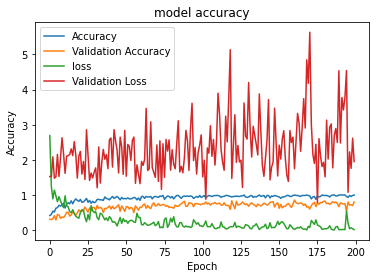

In [64]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [65]:
print(test_batches.classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [88]:
prediction = new_model.predict(test_batches)


In [90]:
import numpy as np
predictions = np.argmax(prediction,axis=1)

print(predictions)

[0 1 0 0 2 2 1 1 0 0 2 2 1 1 0 0 2 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 2 0 2 2 1 0 2 2 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 3 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 2 2 1
 2 0 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 0 2 1 0 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 0 0 0 1 3 3 3 3 3 3]


In [105]:
from sklearn import metrics

print(metrics.confusion_matrix(test_batches.classes,predictions))


target_names = ['class 0: glioma_tumor','class 1: meningioma_tumor','class 2: no_tumor','class 3: pituitary_tumor']

print(metrics.classification_report(test_batches.classes,predictions,target_names = target_names))

[[27 12 11  0]
 [ 2 55  0  1]
 [ 3  3 47  0]
 [ 3  2  0 32]]
                           precision    recall  f1-score   support

    class 0: glioma_tumor       0.77      0.54      0.64        50
class 1: meningioma_tumor       0.76      0.95      0.85        58
        class 2: no_tumor       0.81      0.89      0.85        53
 class 3: pituitary_tumor       0.97      0.86      0.91        37

                 accuracy                           0.81       198
                macro avg       0.83      0.81      0.81       198
             weighted avg       0.82      0.81      0.81       198

